In [1]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from tslearn.preprocessing import TimeSeriesScalerMinMax
sys.path.append(os.path.join(os.path.dirname('Demand_class'), '..', 'src'))
from Demand_class import Demand

In [2]:
path = '../data/demand_lower_48'

In [3]:
nat_dem = Demand()

In [4]:
nat_dem.load_data(path)

In [5]:
df = nat_dem.dataframe

In [6]:
df.head()

,Time,Megawatthours
0,2015-07-01 02:00:00,335153
1,2015-07-01 03:00:00,333837
2,2015-07-01 04:00:00,398386
3,2015-07-01 05:00:00,388954
4,2015-07-01 06:00:00,392487


In [7]:
lagged_df = nat_dem.create_lag_variables(df, 24)

In [8]:
lagged_df.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
24,2015-07-02 02:00:00,429199,335153,333837,398386,388954,392487,404647,422227,442131,...,587405,594477,595242,586317,572656,554682,543332,520871,485722,453284
25,2015-07-02 03:00:00,407007,333837,398386,388954,392487,404647,422227,442131,464371,...,594477,595242,586317,572656,554682,543332,520871,485722,453284,429199
26,2015-07-02 04:00:00,395194,398386,388954,392487,404647,422227,442131,464371,491512,...,595242,586317,572656,554682,543332,520871,485722,453284,429199,407007
27,2015-07-02 05:00:00,387654,388954,392487,404647,422227,442131,464371,491512,518043,...,586317,572656,554682,543332,520871,485722,453284,429199,407007,395194
28,2015-07-02 06:00:00,390157,392487,404647,422227,442131,464371,491512,518043,540514,...,572656,554682,543332,520871,485722,453284,429199,407007,395194,387654


In [9]:
X_train, X_test, y_train, y_test = nat_dem.scale_split(lagged_df, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [10]:
X_train, X_test, y_train, y_test = nat_dem.reshape_for_rnn(X_train, X_test, y_train, y_test)

In [11]:
X_train.shape

(40895, 24, 1)

In [12]:
rnn_model = Sequential()
rnn_model

In [14]:
rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 200)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [15]:
rnn_model.compile(optimizer='adam', loss='MSE')

In [16]:
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
41/41 [==============================] - 7s 163ms/step - loss: 0.4662
Epoch 2/10
41/41 [==============================] - 7s 162ms/step - loss: 0.1596
Epoch 3/10
41/41 [==============================] - 7s 163ms/step - loss: 0.0907
Epoch 4/10
41/41 [==============================] - 7s 163ms/step - loss: 0.0510
Epoch 5/10
41/41 [==============================] - 7s 162ms/step - loss: 0.0297
Epoch 6/10
41/41 [==============================] - 7s 166ms/step - loss: 0.0199
Epoch 7/10
41/41 [==============================] - 7s 176ms/step - loss: 0.0157
Epoch 8/10
41/41 [==============================] - 7s 164ms/step - loss: 0.0127
Epoch 9/10
41/41 [==============================] - 7s 164ms/step - loss: 0.0106
Epoch 10/10
41/41 [==============================] - 7s 163ms/step - loss: 0.0097


In [17]:
lag_24_preds = rnn_model.predict(X_test)

In [18]:
lag_24_preds

array([[0.38426366],
       [0.3514991 ],
       [0.32081026],
       ...,
       [0.2277543 ],
       [0.24565192],
       [0.2683074 ]], dtype=float32)

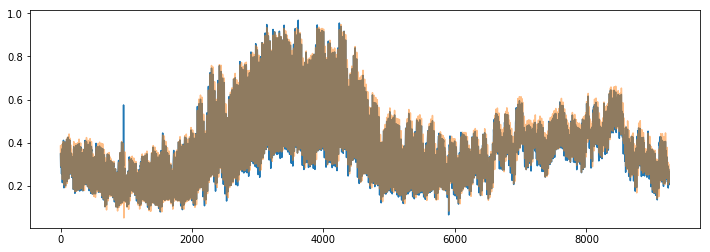

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(y_test)), y_test)
ax.plot(range(len(y_test)), lag_24_preds, alpha=0.5)

plt.show()

In [36]:
mean_absolute_error(y_test, lag_24_preds)

0.01987539893576747

## n-ahead = 24

In [21]:
n_ahead_24 = Demand()

In [22]:
n_ahead_24.load_data(path)

In [23]:
df_24 = n_ahead_24.dataframe

In [24]:
df_24 = n_ahead_24.create_lag_variables(df_24, 24, 24)

In [25]:
df_24.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
48,2015-07-03 02:00:00,415203,335153,333837,398386,388954,392487,404647,422227,442131,...,587405,594477,595242,586317,572656,554682,543332,520871,485722,453284
49,2015-07-03 03:00:00,394227,333837,398386,388954,392487,404647,422227,442131,464371,...,594477,595242,586317,572656,554682,543332,520871,485722,453284,429199
50,2015-07-03 04:00:00,383147,398386,388954,392487,404647,422227,442131,464371,491512,...,595242,586317,572656,554682,543332,520871,485722,453284,429199,407007
51,2015-07-03 05:00:00,373941,388954,392487,404647,422227,442131,464371,491512,518043,...,586317,572656,554682,543332,520871,485722,453284,429199,407007,395194
52,2015-07-03 06:00:00,371552,392487,404647,422227,442131,464371,491512,518043,540514,...,572656,554682,543332,520871,485722,453284,429199,407007,395194,387654


In [50]:
X_train_24, X_test_24, y_train_24, y_test_24 = n_ahead_24.scale_split(df_24, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [51]:
X_train_24, X_test_24, y_train_24, y_test_24 = n_ahead_24.reshape_for_rnn(X_train_24, X_test_24, y_train_24, y_test_24)

In [52]:
X_train_24.shape

(40871, 24, 1)

In [53]:
rnn_24 = Sequential()

In [54]:
rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_24.shape[1], 1)))
rnn_24.add(Dropout(0.15))

rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_24.add(Dropout(0.15))

rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_24.add(Dropout(0.15))

rnn_24.add(Dense(1))

rnn_24.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 24, 200)           40400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [55]:
rnn_24.compile(optimizer='adam', loss='MSE')

In [56]:
rnn_24.fit(X_train_24, y_train_24, epochs=10, batch_size=1000)

Epoch 1/10
41/41 [==============================] - 7s 164ms/step - loss: 0.4836
Epoch 2/10
41/41 [==============================] - 7s 165ms/step - loss: 0.1600
Epoch 3/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0956
Epoch 4/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0496
Epoch 5/10
41/41 [==============================] - 7s 163ms/step - loss: 0.0316
Epoch 6/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0230
Epoch 7/10
41/41 [==============================] - 7s 163ms/step - loss: 0.0194
Epoch 8/10
41/41 [==============================] - 7s 162ms/step - loss: 0.0160
Epoch 9/10
41/41 [==============================] - 7s 162ms/step - loss: 0.0138
Epoch 10/10
41/41 [==============================] - 7s 162ms/step - loss: 0.0130


In [57]:
ahead_24_preds = rnn_24.predict(X_test_24)

In [58]:
ahead_24_preds

array([[0.34960034],
       [0.3232784 ],
       [0.30439973],
       ...,
       [0.22959694],
       [0.2425889 ],
       [0.25506428]], dtype=float32)

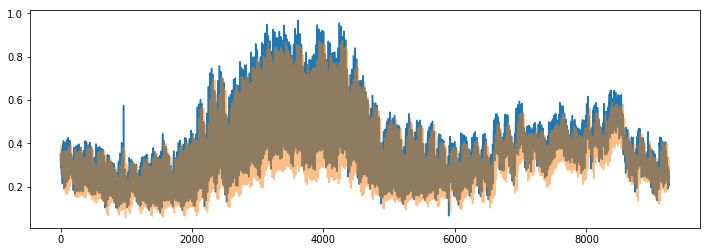

In [59]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(y_test_24)), y_test_24)
ax.plot(range(len(y_test_24)), ahead_24_preds, alpha=0.5)

plt.show()

In [60]:
mean_absolute_error(y_test_24, ahead_24_preds)

0.0466531161095849

## Month in advance

In [74]:
month_ahead = Demand()

In [75]:
month_ahead.load_data(path)

In [76]:
n_ahead_720 = month_ahead.dataframe

In [77]:
df_720 = month_ahead.create_lag_variables(n_ahead_720, 720, 720)

In [78]:
df_720.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,710,711,712,713,714,715,716,717,718,719
1440,2015-08-30 02:00:00,415541,335153,333837,398386,388954,392487,404647,422227,442131,...,682163,688288,689487,682378,666540,649856,632088,599934,559580,521564
1441,2015-08-30 03:00:00,397124,333837,398386,388954,392487,404647,422227,442131,464371,...,688288,689487,682378,666540,649856,632088,599934,559580,521564,485347
1442,2015-08-30 04:00:00,382141,398386,388954,392487,404647,422227,442131,464371,491512,...,689487,682378,666540,649856,632088,599934,559580,521564,485347,457572
1443,2015-08-30 05:00:00,372201,388954,392487,404647,422227,442131,464371,491512,518043,...,682378,666540,649856,632088,599934,559580,521564,485347,457572,437938
1444,2015-08-30 06:00:00,367829,392487,404647,422227,442131,464371,491512,518043,540514,...,666540,649856,632088,599934,559580,521564,485347,457572,437938,426952


In [79]:
X_train_720, X_test_720, y_train_720, y_test_720 = month_ahead.scale_split(df_720, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [80]:
X_train_720, X_test_720, y_train_720, y_test_720 = month_ahead.reshape_for_rnn(X_train_720, X_test_720, y_train_720, y_test_720)

In [81]:
rnn_720 = Sequential()

In [82]:
rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_720.shape[1], 1)))
rnn_720.add(Dropout(0.15))

rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_720.add(Dropout(0.15))

rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_720.add(Dropout(0.15))

rnn_720.add(Dense(1))

rnn_720.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 720, 200)          40400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 720, 200)          0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 720, 200)          80200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 720, 200)          0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [83]:
rnn_720.compile(optimizer='adam', loss='MSE')

In [84]:
rnn_720.fit(X_train_720, y_train_720, epochs=10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 205s 5s/step - loss: 0.4959
Epoch 2/10
40/40 [==============================] - 203s 5s/step - loss: 0.2157
Epoch 3/10
40/40 [==============================] - 202s 5s/step - loss: 0.1725
Epoch 4/10
40/40 [==============================] - 205s 5s/step - loss: 0.1281
Epoch 5/10
40/40 [==============================] - 210s 5s/step - loss: 0.1081
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 0.0930
Epoch 7/10
40/40 [==============================] - 206s 5s/step - loss: 0.0811
Epoch 8/10
40/40 [==============================] - 205s 5s/step - loss: 0.0732
Epoch 9/10
40/40 [==============================] - 205s 5s/step - loss: 0.0671
Epoch 10/10
40/40 [==============================] - 206s 5s/step - loss: 0.0633


In [85]:
ahead_720_preds = rnn_720.predict(X_test_720)

In [86]:
ahead_720_preds

array([[0.5477178 ],
       [0.5341457 ],
       [0.51582193],
       ...,
       [0.55195224],
       [0.53997684],
       [0.5333997 ]], dtype=float32)

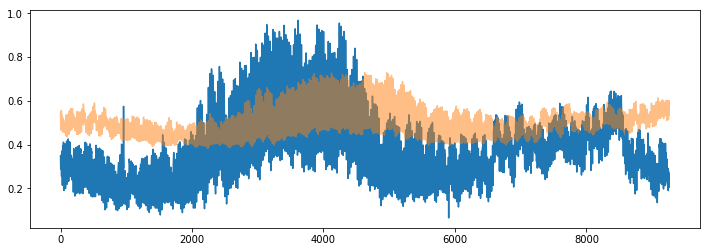

In [87]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(y_test_720)), y_test_720)
ax.plot(range(len(y_test_720)), ahead_720_preds, alpha=0.5)

plt.show()

In [88]:
mean_absolute_error(y_test_720, ahead_720_preds)

0.15760814739307893